In [25]:
import numpy as np
from urllib import request
import gzip
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import preprocessing

In [2]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [3]:
def softmax(x):
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, keepdims = True)
    s = x_exp / x_sum
    return s

In [4]:
W = np.array([[1.,1.,1.],[-1.,-1.,-1.]])
b = np.array([0.,0.,0.])
V = np.array([[1.,1.],[-1.,-1.],[-1.,-1.]])
c = np.array([0.,0.])
x = np.array([1,-1])
t = np.array([1,0])
parameters = {"W": W,
              "b": b,
              "V": V,
              "c": c}

In [4]:
def initial_weights():
    W = np.random.randn(2,3)
    b = np.zeros(3,)
    V = np.random.randn(3,2)
    c = np.zeros(2,)
    
    parameters = {"W": W,
                  "b": b,
                  "V": V,
                  "c": c}
    return parameters

In [5]:
def forward(x, parameters):
    W,b,V,c = parameters['W'], parameters['b'], parameters['V'], parameters['c']
    # calculate linear output k
    k = np.array([0.,0.,0.])
    for i in range(2):
        for j in range(3):
            k[j] += W[i,j] * x[i]
        k[j] += b[j]
    
    # calculate sigmoid function
    h = np.array([0.,0.,0.])
    for i in range(3):
        h[i] = sigmoid(k[i])
    
    # calculate linear output z
    z = np.array([0.,0.])
    for i in range(2):
        for j in range(3):
            z[i] += V[j,i] * h[j]
        z[i] += c[i]
    
    # calculate softmax function y
    y = softmax(z)
    
    cache = {'z':z,
             'h':h,
             'k':k,
             }
    return y, cache

In [23]:
def cross_entropy(p,y):
    logprobs = (np.log(p) * y) + (np.log(1 - p) * (1 - y))
    loss = -np.sum(logprobs)/2
    return loss

In [7]:
def delta_cross_entropy(p,y):
    dloss = p - y
    return dloss

In [8]:
def backward(y,t,x,cache,parameters):
    
    loss = cross_entropy(y,t)
    dloss = delta_cross_entropy(y,t)
    z, h, k = cache['z'], cache['h'], cache['k']
    V = parameters['V']
    
    # calculte dV, dc
    dV = np.array([[0.,0.],[0.,0.],[0.,0.]])
    dh = np.array([0.,0.,0.])
    for i in range(3):
        for j in range(2):
            dV[i,j] = dloss[j] * h[i]
            dh[i] += dloss[j] * V[i,j]
    
    dc = dloss
    
    #calculate dk
    dk = np.array([0.,0.,0.])
    for i in range(3):
        dk[i] = dh[i] * h[i] *(1-h[i])
    
    #calculate dW, db
    dW = np.array([[0.,0.,0.],[0.,0.,0.]])
    for i in range(2):
        for j in range(3):
            dW[i,j] = dk[j] * x[i]
            
    db = dk
    
    grads = {'dW':dW,
             'db':db,
             'dV':dV,
             'dc':dc,
            }
    return grads

In [10]:
y, cache = forward(x, parameters)
grads = backward(y,t,x,cache,parameters)
print(grads)

{'dW': array([[ 0.,  0.,  0.],
       [-0., -0., -0.]]), 'db': array([0., 0., 0.]), 'dV': array([[-0.44039854,  0.44039854],
       [-0.44039854,  0.44039854],
       [-0.44039854,  0.44039854]]), 'dc': array([-0.5,  0.5])}


In [32]:
def update_parameters(parameters, grads,learning_rate = np.exp(-4)):
    # get weights
    W,b,V,c = parameters['W'], parameters['b'], parameters['V'], parameters['c']
   
    # get gridient
    dW,db,dV,dc = grads['dW'], grads['db'], grads['dV'], grads['dc']
   
    # update weights 
    W = W - learning_rate * dW
    b = b - learning_rate * db
    V = V - learning_rate * dV
    c = c - learning_rate * dc
    
    parameters = {"W": W,
                  "b": b,
                  "V": V,
                  "c": c}
    
    return parameters

In [12]:
def convert_onehot(t):
    t = np.eye(2)[t]
    return t

In [33]:
def nn_model(train_data,t,num_iterations,epoch):
    parameters = initial_weights()
    t = convert_onehot(t)
    loss_avg = []
    # gridient descent
    for e in range(epoch):
        loss = []
        print('tarining epoch %i'% e)
        for i in range(0, num_iterations):
            x = train_data[i]
            y, cache = forward(x, parameters)
            cost = cross_entropy(y,t[i])
            grads = backward(y,t[i],x,cache,parameters)
            parameters = update_parameters(parameters,grads,learning_rate = np.exp(-4))
            loss.append(cost)
            #print cost
            if i % 3000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
        loss_avg.append(np.mean(loss))
    return parameters, loss_avg

In [37]:
def load_synth(num_train=60_000, num_val=10_000):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples (xtrain, ytrain), (xval, yval) the training data is a floating point numpy array:
    """
    np.random.seed(654)
    THRESHOLD = 0.6
    quad = np.asarray([[1, 0.5], [1, .2]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

In [41]:
train_data, test_data, num = load_synth()

In [43]:
min_max_scaler = preprocessing.MinMaxScaler()
train_minmax = min_max_scaler.fit_transform(train_data[0])
print(train_minmax)

[[0.70294642 0.3866575 ]
 [0.64931516 0.49083875]
 [0.60286147 0.67254102]
 ...
 [0.49385492 0.41891501]
 [0.63948189 0.42996102]
 [0.57887888 0.61770805]]


In [44]:
parameters,loss = nn_model(train_minmax,train_data[1],60000,100)

tarining epoch 0
Cost after iteration 0: 2.197919
Cost after iteration 3000: 0.640049
Cost after iteration 6000: 0.951114
Cost after iteration 9000: 0.699704
Cost after iteration 12000: 0.924761
Cost after iteration 15000: 0.413399
Cost after iteration 18000: 0.875130
Cost after iteration 21000: 0.690402
Cost after iteration 24000: 1.114893
Cost after iteration 27000: 0.464918
Cost after iteration 30000: 0.892710
Cost after iteration 33000: 0.583575
Cost after iteration 36000: 0.597145
Cost after iteration 39000: 0.664621
Cost after iteration 42000: 0.504762
Cost after iteration 45000: 0.596576
Cost after iteration 48000: 0.618347
Cost after iteration 51000: 0.843422
Cost after iteration 54000: 0.575828
Cost after iteration 57000: 0.639896
tarining epoch 1
Cost after iteration 0: 0.576209
Cost after iteration 3000: 0.664575
Cost after iteration 6000: 0.868941
Cost after iteration 9000: 0.771012
Cost after iteration 12000: 0.936673
Cost after iteration 15000: 0.440991
Cost after iterati

Cost after iteration 57000: 0.225956
tarining epoch 11
Cost after iteration 0: 0.799270
Cost after iteration 3000: 0.159747
Cost after iteration 6000: 0.922320
Cost after iteration 9000: 0.000008
Cost after iteration 12000: 0.000018
Cost after iteration 15000: 0.028065
Cost after iteration 18000: 0.084246
Cost after iteration 21000: 0.001930
Cost after iteration 24000: 0.000026
Cost after iteration 27000: 0.069526
Cost after iteration 30000: 0.459761
Cost after iteration 33000: 0.147634
Cost after iteration 36000: 0.082855
Cost after iteration 39000: 0.258053
Cost after iteration 42000: 0.057107
Cost after iteration 45000: 0.157727
Cost after iteration 48000: 0.000015
Cost after iteration 51000: 0.084482
Cost after iteration 54000: 0.228807
Cost after iteration 57000: 0.214094
tarining epoch 12
Cost after iteration 0: 0.830500
Cost after iteration 3000: 0.150514
Cost after iteration 6000: 0.899521
Cost after iteration 9000: 0.000014
Cost after iteration 12000: 0.000035
Cost after itera

Cost after iteration 54000: 0.216461
Cost after iteration 57000: 0.146287
tarining epoch 22
Cost after iteration 0: 1.088357
Cost after iteration 3000: 0.100592
Cost after iteration 6000: 0.765312
Cost after iteration 9000: 0.005280
Cost after iteration 12000: 0.020305
Cost after iteration 15000: 0.008302
Cost after iteration 18000: 0.064544
Cost after iteration 21000: 0.002386
Cost after iteration 24000: 0.004147
Cost after iteration 27000: 0.034433
Cost after iteration 30000: 0.270615
Cost after iteration 33000: 0.119383
Cost after iteration 36000: 0.037761
Cost after iteration 39000: 0.204952
Cost after iteration 42000: 0.019425
Cost after iteration 45000: 0.108470
Cost after iteration 48000: 0.001382
Cost after iteration 51000: 0.050088
Cost after iteration 54000: 0.215597
Cost after iteration 57000: 0.142724
tarining epoch 23
Cost after iteration 0: 1.105854
Cost after iteration 3000: 0.097888
Cost after iteration 6000: 0.758978
Cost after iteration 9000: 0.006081
Cost after itera

Cost after iteration 51000: 0.038676
Cost after iteration 54000: 0.208083
Cost after iteration 57000: 0.119800
tarining epoch 33
Cost after iteration 0: 1.237390
Cost after iteration 3000: 0.079651
Cost after iteration 6000: 0.720275
Cost after iteration 9000: 0.012589
Cost after iteration 12000: 0.053085
Cost after iteration 15000: 0.004814
Cost after iteration 18000: 0.055717
Cost after iteration 21000: 0.002241
Cost after iteration 24000: 0.008703
Cost after iteration 27000: 0.022344
Cost after iteration 30000: 0.201722
Cost after iteration 33000: 0.103204
Cost after iteration 36000: 0.027285
Cost after iteration 39000: 0.187070
Cost after iteration 42000: 0.011800
Cost after iteration 45000: 0.090948
Cost after iteration 48000: 0.002565
Cost after iteration 51000: 0.037967
Cost after iteration 54000: 0.207465
Cost after iteration 57000: 0.118315
tarining epoch 34
Cost after iteration 0: 1.247354
Cost after iteration 3000: 0.078411
Cost after iteration 6000: 0.717818
Cost after iter

Cost after iteration 48000: 0.003295
Cost after iteration 51000: 0.033056
Cost after iteration 54000: 0.202292
Cost after iteration 57000: 0.107352
tarining epoch 44
Cost after iteration 0: 1.327294
Cost after iteration 3000: 0.069066
Cost after iteration 6000: 0.699462
Cost after iteration 9000: 0.017136
Cost after iteration 12000: 0.074580
Cost after iteration 15000: 0.003607
Cost after iteration 18000: 0.052254
Cost after iteration 21000: 0.002254
Cost after iteration 24000: 0.011690
Cost after iteration 27000: 0.017160
Cost after iteration 30000: 0.165724
Cost after iteration 33000: 0.092178
Cost after iteration 36000: 0.023038
Cost after iteration 39000: 0.176961
Cost after iteration 42000: 0.008901
Cost after iteration 45000: 0.081861
Cost after iteration 48000: 0.003357
Cost after iteration 51000: 0.032716
Cost after iteration 54000: 0.201855
Cost after iteration 57000: 0.106527
tarining epoch 45
Cost after iteration 0: 1.333732
Cost after iteration 3000: 0.068355
Cost after ite

Cost after iteration 48000: 0.003899
Cost after iteration 51000: 0.030182
Cost after iteration 54000: 0.198047
Cost after iteration 57000: 0.099851
tarining epoch 55
Cost after iteration 0: 1.387327
Cost after iteration 3000: 0.062601
Cost after iteration 6000: 0.686419
Cost after iteration 9000: 0.020064
Cost after iteration 12000: 0.088208
Cost after iteration 15000: 0.003008
Cost after iteration 18000: 0.050708
Cost after iteration 21000: 0.002328
Cost after iteration 24000: 0.013790
Cost after iteration 27000: 0.014375
Cost after iteration 30000: 0.143447
Cost after iteration 33000: 0.084315
Cost after iteration 36000: 0.020745
Cost after iteration 39000: 0.169778
Cost after iteration 42000: 0.007391
Cost after iteration 45000: 0.076133
Cost after iteration 48000: 0.003946
Cost after iteration 51000: 0.029993
Cost after iteration 54000: 0.197712
Cost after iteration 57000: 0.099303
tarining epoch 56
Cost after iteration 0: 1.391789
Cost after iteration 3000: 0.062131
Cost after ite

Cost after iteration 45000: 0.072393
Cost after iteration 48000: 0.004368
Cost after iteration 51000: 0.028517
Cost after iteration 54000: 0.194692
Cost after iteration 57000: 0.094608
tarining epoch 66
Cost after iteration 0: 1.429723
Cost after iteration 3000: 0.058151
Cost after iteration 6000: 0.676962
Cost after iteration 9000: 0.022054
Cost after iteration 12000: 0.097069
Cost after iteration 15000: 0.002647
Cost after iteration 18000: 0.049978
Cost after iteration 21000: 0.002419
Cost after iteration 24000: 0.015335
Cost after iteration 27000: 0.012650
Cost after iteration 30000: 0.128157


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Cost after iteration 33000: 0.078408
Cost after iteration 36000: 0.019277
Cost after iteration 39000: 0.164118
Cost after iteration 42000: 0.006455
Cost after iteration 45000: 0.072071
Cost after iteration 48000: 0.004406
Cost after iteration 51000: 0.028403
Cost after iteration 54000: 0.194419
Cost after iteration 57000: 0.094202
tarining epoch 67
Cost after iteration 0: 1.432942
Cost after iteration 3000: 0.057812
Cost after iteration 6000: 0.676218
Cost after iteration 9000: 0.022203
Cost after iteration 12000: 0.097708
Cost after iteration 15000: 0.002621
Cost after iteration 18000: 0.049936
Cost after iteration 21000: 0.002428
Cost after iteration 24000: 0.015454
Cost after iteration 27000: 0.012526
Cost after iteration 30000: 0.126996
Cost after iteration 33000: 0.077941
Cost after iteration 36000: 0.019168
Cost after iteration 39000: 0.163656
Cost after iteration 42000: 0.006387
Cost after iteration 45000: 0.071756
Cost after iteration 48000: 0.004442
Cost after iteration 51000:

Cost after iteration 30000: 0.116900
Cost after iteration 33000: 0.073770
Cost after iteration 36000: 0.018232
Cost after iteration 39000: 0.159411
Cost after iteration 42000: 0.005809
Cost after iteration 45000: 0.068966
Cost after iteration 48000: 0.004773
Cost after iteration 51000: 0.027402
Cost after iteration 54000: 0.191669
Cost after iteration 57000: 0.090284
tarining epoch 78
Cost after iteration 0: 1.463047
Cost after iteration 3000: 0.054579
Cost after iteration 6000: 0.668953
Cost after iteration 9000: 0.023571
Cost after iteration 12000: 0.103396
Cost after iteration 15000: 0.002385
Cost after iteration 18000: 0.049648
Cost after iteration 21000: 0.002521
Cost after iteration 24000: 0.016596
Cost after iteration 27000: 0.011393
Cost after iteration 30000: 0.116018
Cost after iteration 33000: 0.073396
Cost after iteration 36000: 0.018151
Cost after iteration 39000: 0.159020
Cost after iteration 42000: 0.005760
Cost after iteration 45000: 0.068718
Cost after iteration 48000:

Cost after iteration 27000: 0.010636
Cost after iteration 30000: 0.108189
Cost after iteration 33000: 0.070002
Cost after iteration 36000: 0.017433
Cost after iteration 39000: 0.155372
Cost after iteration 42000: 0.005332
Cost after iteration 45000: 0.066473
Cost after iteration 48000: 0.005072
Cost after iteration 51000: 0.026742
Cost after iteration 54000: 0.189294
Cost after iteration 57000: 0.087109
tarining epoch 89
Cost after iteration 0: 1.485516
Cost after iteration 3000: 0.052032
Cost after iteration 6000: 0.662970
Cost after iteration 9000: 0.024571
Cost after iteration 12000: 0.107237
Cost after iteration 15000: 0.002211
Cost after iteration 18000: 0.049585
Cost after iteration 21000: 0.002610
Cost after iteration 24000: 0.017480
Cost after iteration 27000: 0.010570
Cost after iteration 30000: 0.107491
Cost after iteration 33000: 0.069694
Cost after iteration 36000: 0.017370
Cost after iteration 39000: 0.155031
Cost after iteration 42000: 0.005294
Cost after iteration 45000:

Cost after iteration 24000: 0.018120
Cost after iteration 27000: 0.009998
Cost after iteration 30000: 0.101196
Cost after iteration 33000: 0.066859
Cost after iteration 36000: 0.016793
Cost after iteration 39000: 0.151830
Cost after iteration 42000: 0.004961
Cost after iteration 45000: 0.064399
Cost after iteration 48000: 0.005320
Cost after iteration 51000: 0.026294
Cost after iteration 54000: 0.187198
Cost after iteration 57000: 0.084442


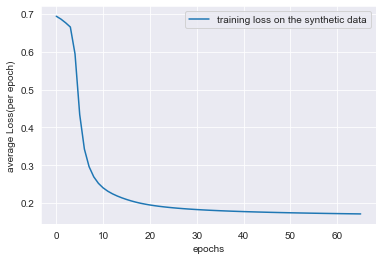

In [53]:
sns.set_style("darkgrid")
x = np.arange(0,100)
sns.lineplot(x = x, y = loss,label = 'training loss on the synthetic data')
plt.xlabel('epochs')
plt.ylabel('average Loss(per epoch)')
plt.legend()
#plt.savefig(r'C:\Users\WXK\Desktop\Deep learning\training loss on the synthetic data.png')